In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/vucar

/content/drive/MyDrive/vucar


## 1. Import libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import check_random_state
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

np.random.seed(0)  # Set seed for numpy
check_random_state(0)  # Set seed for sklearn

RandomState(MT19937) at 0x7BB6F89B1A40

## 2. Read dataset & EDA

In [43]:
df = pd.read_csv('car.csv')

In [44]:
df

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317631,148874300,108958993,1696836032000,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used
317632,150398284,110264477,1695692918000,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317633,150748445,110565749,1696580444000,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317634,150811050,110619804,1696753826000,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used


In [45]:
# Filter used cars
dataset = df[df['condition'] == 'used']
dataset = dataset.drop(columns=['condition', 'id', 'list_id', 'list_time'])

# Drop NaN values
dataset = dataset.dropna()

# Calculate the brand that constitute 90% of the total cars
brand_counts = dataset['brand'].value_counts(normalize=True).cumsum()
selected_brands = brand_counts[brand_counts <= 0.9].index.tolist()
# Filter the data to only include selected brands
dataset = dataset[dataset['brand'].isin(selected_brands)]

In [23]:
dataset

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0
...,...,...,...,...,...,...,...,...,...,...,...
317623,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,305000000.0
317626,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,305000000.0
317629,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0
317632,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0


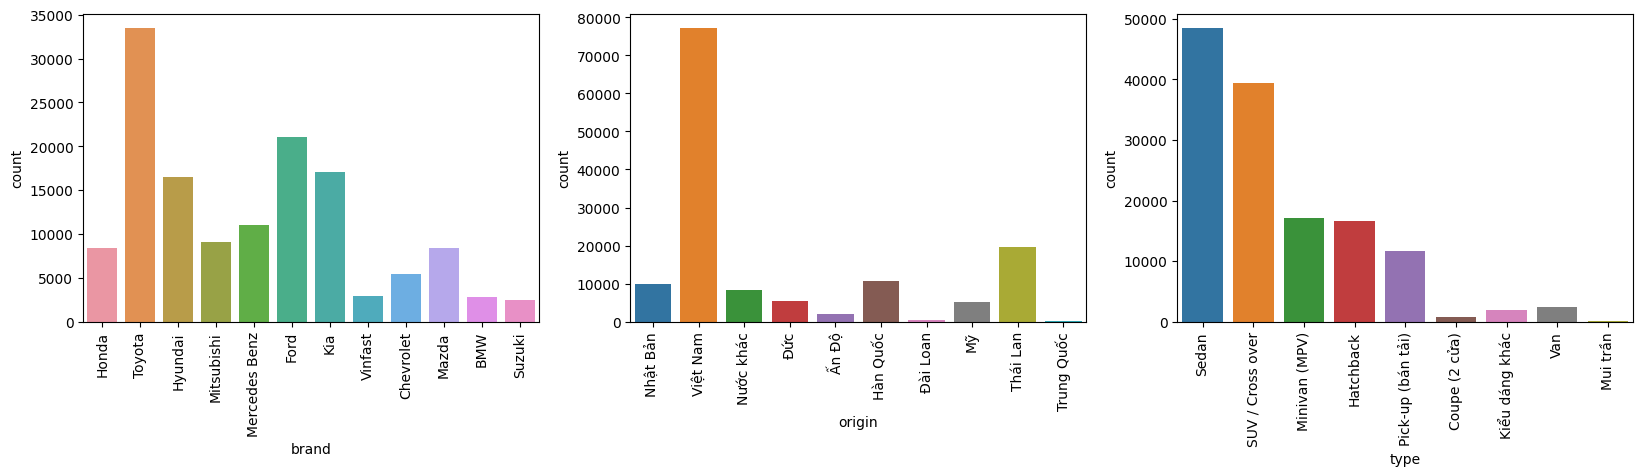

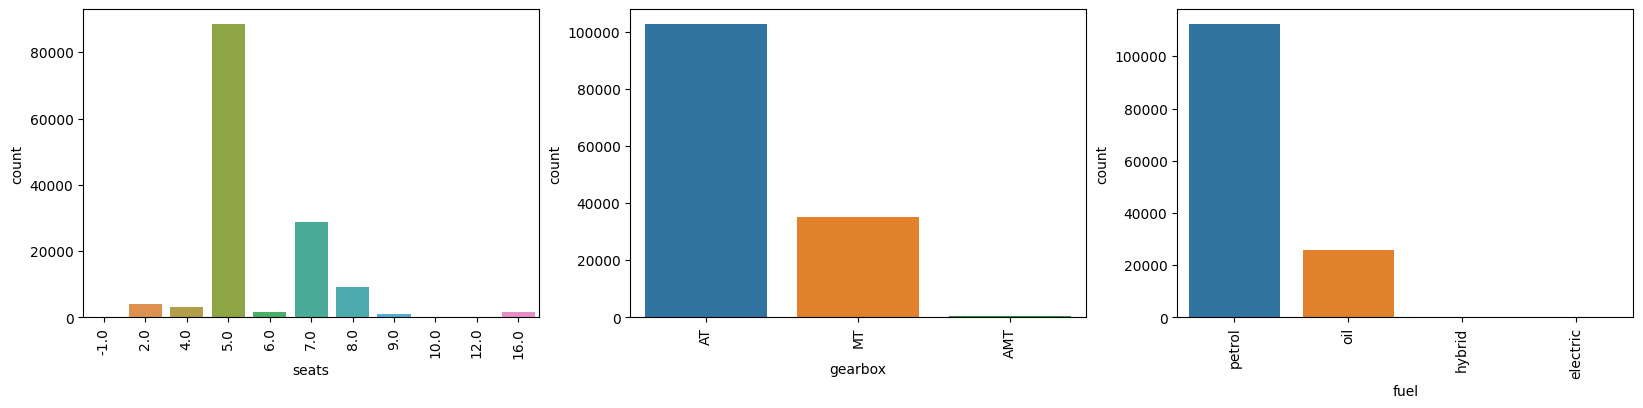

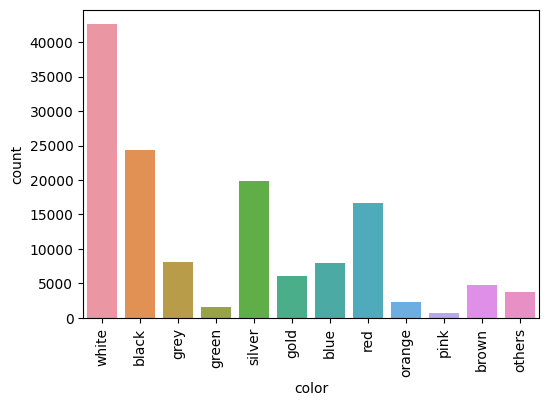

In [47]:
# Categorical Data
cat_cols = ['brand', 'origin', 'type', 'seats', 'gearbox', 'fuel', 'color']

i = 0
while i < 7:
    fig = plt.figure(figsize=[20,4])

    plt.subplot(1,3,1)
    sns.countplot(x=cat_cols[i], data=dataset)
    plt.xticks(rotation=90)  # Rotate x-axis labels

    i += 1
    if i == 7: break
    plt.subplot(1,3,2)
    sns.countplot(x=cat_cols[i], data=dataset)
    plt.xticks(rotation=90)  # Rotate x-axis labels

    i += 1
    plt.subplot(1,3,3)
    sns.countplot(x=cat_cols[i], data=dataset)
    plt.xticks(rotation=90)  # Rotate x-axis labels

    i += 1
    plt.show()


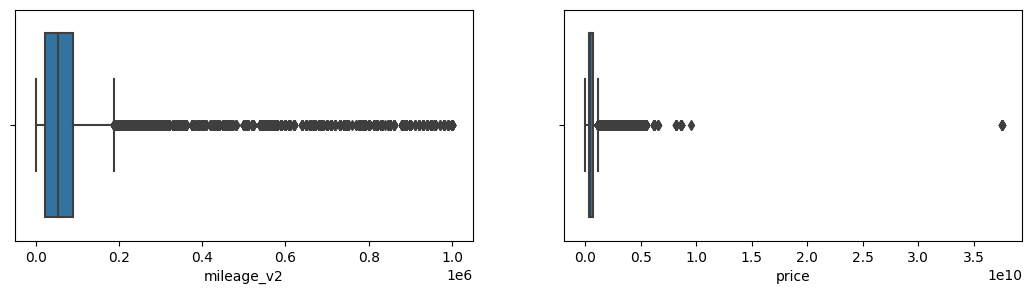

In [48]:
# Numeric data

num_cols = ['mileage_v2','price']


fig = plt.figure(figsize=[13,3])

plt.subplot(1,2,1)
sns.boxplot(x=num_cols[0], data=dataset)


plt.subplot(1,2,2)
sns.boxplot(x=num_cols[1], data=dataset)

plt.show()

<Figure size 2500x600 with 0 Axes>

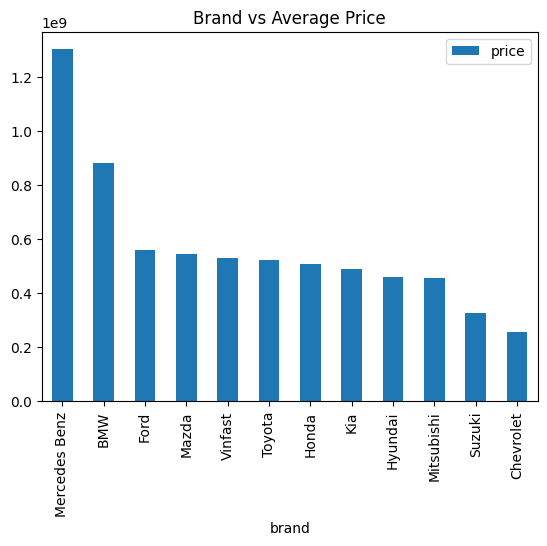

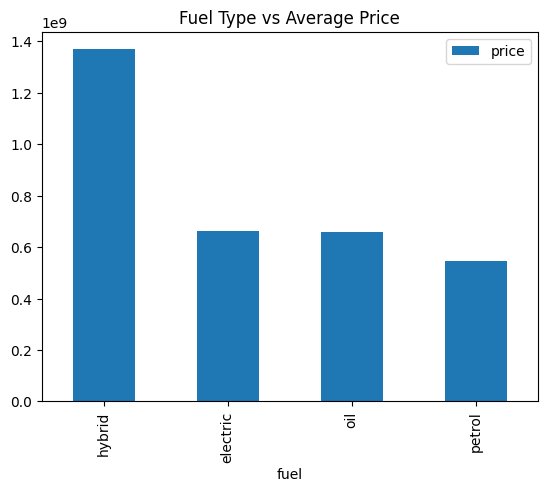

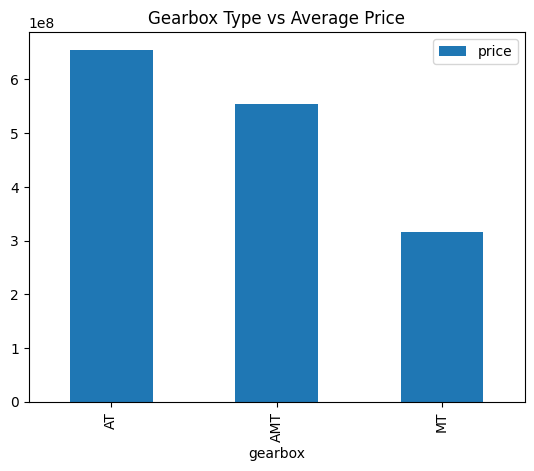

In [27]:
# Plot

plt.figure(figsize=(25, 6))

df = pd.DataFrame(dataset.groupby(['brand'])['price'].mean().sort_values(ascending = False))
df.plot.bar()
plt.title('Brand vs Average Price')
plt.show()

df = pd.DataFrame(dataset.groupby(['fuel'])['price'].mean().sort_values(ascending = False))
df.plot.bar()
plt.title('Fuel Type vs Average Price')
plt.show()

df = pd.DataFrame(dataset.groupby(['gearbox'])['price'].mean().sort_values(ascending = False))
df.plot.bar()
plt.title('Gearbox Type vs Average Price')
plt.show()

In [28]:
# Covert dategorical data
cols = ['manufacture_date', 'brand', 'model', 'origin', 'type', 'seats', 'gearbox', 'fuel', 'color']
category_mapping = {}
for col in cols:
    category_mapping[col] = dict(enumerate(dataset[col].astype('category').cat.categories))
    category_mapping[col] = {v: k for k, v in category_mapping[col].items()}
dataset[cols] = dataset[cols].apply(lambda x: x.astype('category').cat.codes)


In [29]:
# Save mapping to index
import json
with open('mapping.json', 'w') as file:
    json.dump(category_mapping, file, indent=4)

In [30]:
dataset

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price
1,40,3,65,2,7,3,1,3,11,23000,455000000.0
3,39,10,235,6,7,3,2,3,11,99999,368000000.0
5,41,4,86,6,7,3,1,3,11,45000,455000000.0
6,37,10,126,6,6,6,2,3,11,60000,485000000.0
7,39,8,250,3,3,5,2,3,11,50000,465000000.0
...,...,...,...,...,...,...,...,...,...,...,...
317623,37,4,116,6,1,3,1,3,9,87000,305000000.0
317626,37,4,116,6,1,3,1,3,9,87000,305000000.0
317629,36,5,192,6,3,5,1,2,11,140000,730000000.0
317632,36,5,192,6,3,5,1,2,11,140000,730000000.0


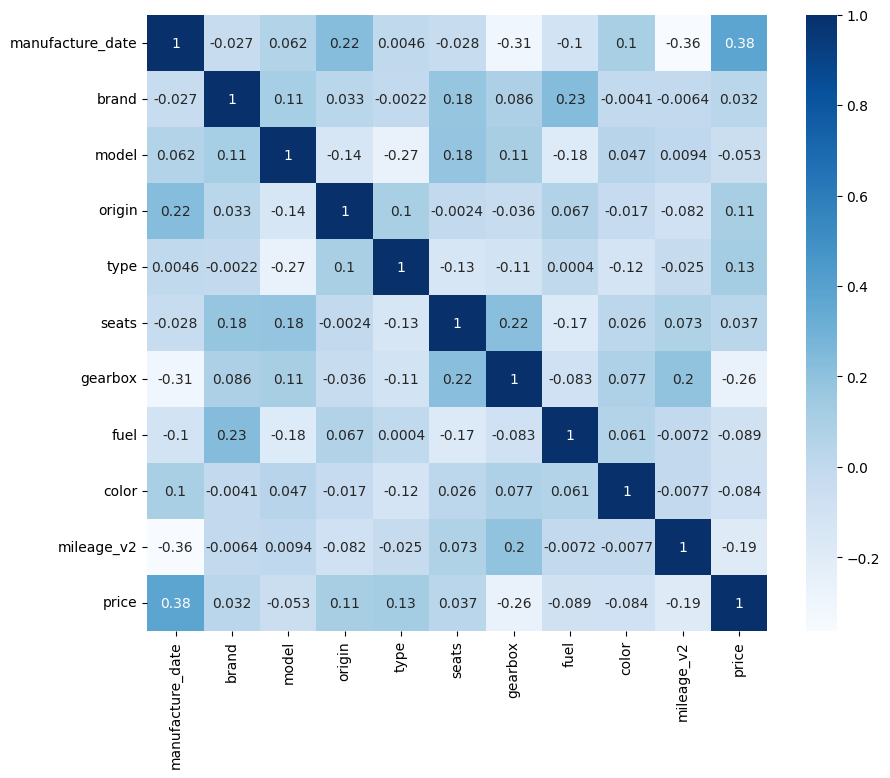

In [31]:
# Correlation features
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, cmap="Blues")
plt.show()

## 3. Training models

In [32]:
# Split data
X = dataset.drop('price', axis=1)
y = dataset['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
CV = []
R2_train = []
R2_test = []

def car_pred_model(model, model_name):
    # Training model
    model.fit(X_train,y_train)

    # R2 score of train set
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train,y_pred_train)
    R2_train.append(round(R2_train_model,2))

    # R2 score of test set
    y_pred_test = model.predict(X_test)
    R2_test_model = r2_score(y_test,y_pred_test)
    R2_test.append(round(R2_test_model,2))

    # R2 mean of train set using Cross validation
    cross_val = cross_val_score(model ,X_train ,y_train ,cv=5)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean,2))

    # Printing results
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    print("Train CV scores :",cross_val)
    print("Train CV mean :",round(cv_mean,2))

    with open(model_name, 'wb') as file:
        pickle.dump(model, file)

    # Plotting Graphs
    # Residual Plot of train data
    fig, ax = plt.subplots(1,2,figsize = (10,4))
    ax[0].set_title('Residual Plot of Train samples')
    sns.distplot((y_train-y_pred_train),hist = False,ax = ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')

    # Y_test vs Y_train scatter plot
    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(x = y_test, y = y_pred_test)
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_pred_test')

    plt.show()

### 3.1. Decision Tree

Train R2-score : 1.0
Test R2-score : 0.99
Train CV scores : [0.99261338 0.99017939 0.98754058 0.97165431 0.9897203 ]
Train CV mean : 0.99


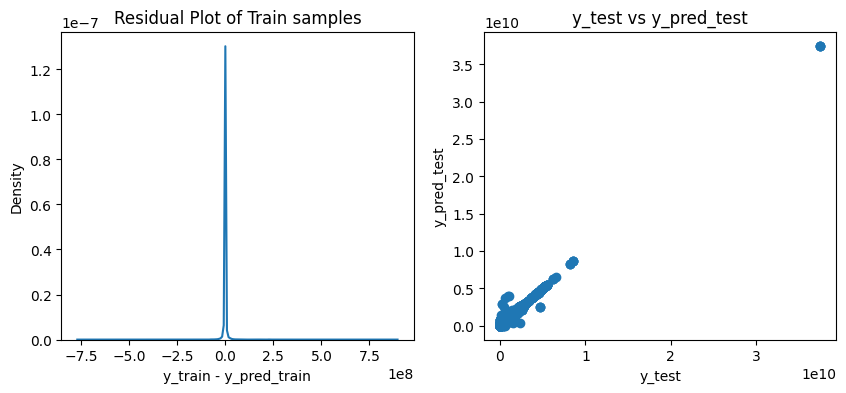

In [34]:
dt = DecisionTreeRegressor()
car_pred_model(dt,"dt.pkl")

### 3.2. Random Forest

Train R2-score : 1.0
Test R2-score : 0.99
Train CV scores : [0.89244254 0.99269664 0.98924623 0.97176337 0.99005908]
Train CV mean : 0.97


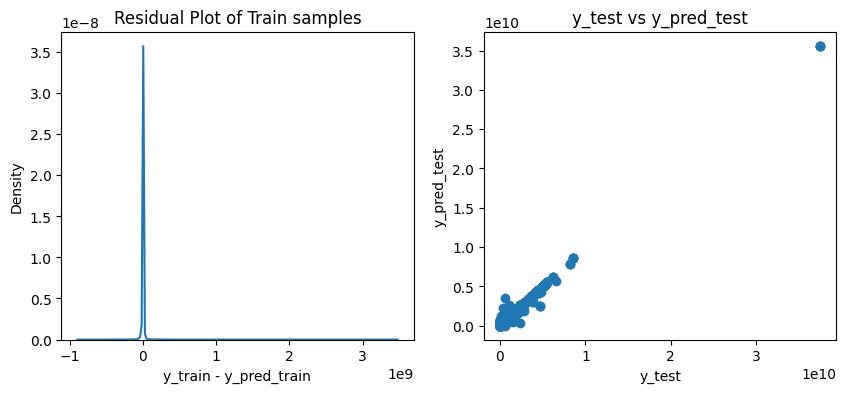

In [35]:
rf = RandomForestRegressor(n_estimators=20)
car_pred_model(rf,"rf.pkl")

### 3.3. LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 97068, number of used features: 10
[LightGBM] [Info] Start training from score 568893728.647938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 77654, number of used features: 10
[LightGBM] [Info] Start training from score 567537615.435676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

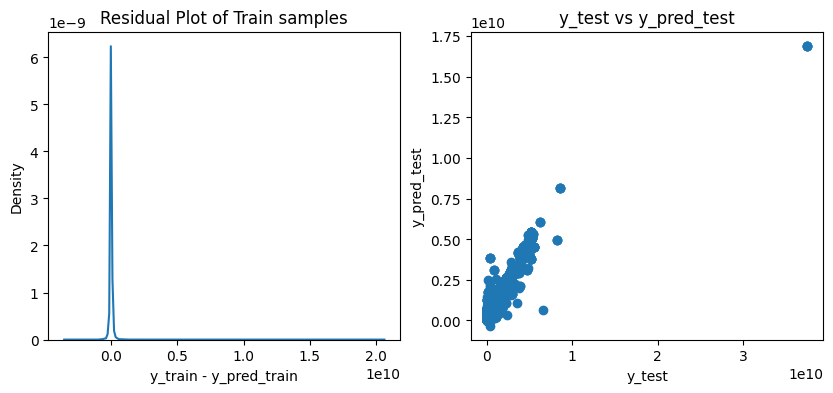

In [36]:
lgbm = LGBMRegressor()
car_pred_model(lgbm,"ldbm.pkl")

### 3.4 XGBoost

Train R2-score : 0.97
Test R2-score : 0.97
Train CV scores : [0.8980146  0.9719539  0.96337982 0.94355891 0.96532648]
Train CV mean : 0.95


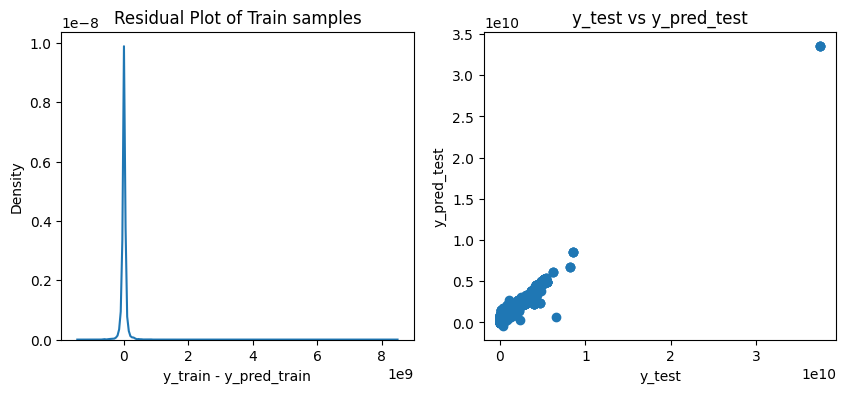

In [37]:
xgb = XGBRegressor()
car_pred_model(xgb,"xgb.pkl")

In [38]:
alrogithm = ["Decision Tree", "Random Forest","LightGBM","XGBoost"]
results=pd.DataFrame({'Model': alrogithm,'R2_Train': R2_train,'R2_Test': R2_test,'CV score mean': CV})
display(results)

,Model,R2_Train,R2_Test,CV score mean
0,Decision Tree,1.00,0.99,0.99
1,Random Forest,1.00,0.99,0.97
2,LightGBM,0.88,0.84,0.81
3,XGBoost,0.97,0.97,0.95
